In [ ]:
# module import
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"

In [ ]:
# 데이터 로드
with open(f"{data_path}/mnist.pickle", 'rb') as f:
    mnist = pickle.load(f)

In [ ]:
# 데이터 확인
dir(mnist)

['DESCR', 'categories', 'data', 'details', 'feature_names', 'target', 'url']

# _1_. 오토인코더 모델 생성

In [ ]:
# input data: 3000개만 사용
X_data = mnist.data[:3000]
X_image = X_data.copy() # 그림 그려 보는 용도
X_target = mnist.target[:3000] # 확인용

In [ ]:
# 데이터 픽셀 표준화
scaler = StandardScaler()
X_data = scaler.fit_transform(X_data.T).T # 표준화 방향 주의

In [ ]:
# conv2d 하기 위해 2차원 이미지 * 3000장으로 변경
X_data = X_data.reshape(-1, 28, 28)
X_data.shape

(3000, 28, 28)

In [ ]:
# 노드 설정
n_height = X_data.shape[1]
n_width = X_data.shape[2]
n_channel = 1 # 흑백 이미지

In [ ]:
# 28 x 28 이미지를 14 x 14로 줄인다.

# 인코더 부분
x_Input = Input(batch_shape=(None, n_height, n_width, n_channel))
e_conv = Conv2D(filters=10, 
                kernel_size=(5, 5), 
                strides=1, 
                padding='SAME', # 패딩 옵션 same: 원래 이미지 사이즈 그대로 출력
                activation='relu')(x_Input)
e_pool = MaxPooling2D(pool_size=(5, 5), # (28 - 5 / 1) + 1 = 24
                      strides=1,
                      padding='VALID')(e_conv)
e_flat = Flatten()(e_pool) # 24*24=576
e_latent = Dense(14*14, activation='linear')(e_flat) # 여기서 축소. 최종
e_latent = Reshape((14, 14, 1))(e_latent) # 디코더 층에 넣기 위함.

# 디코더 부분
d_conv_t = Conv2DTranspose(filters=10, 
                           kernel_size=(4, 4),
                           strides=2, # 14*14 -> 28*28
                           padding='SAME', # SAME이면 변 길이 x 스트라이드
                           activation='relu')(e_latent)
x_Output = Conv2D(filters=1, 
                  kernel_size=(4, 4),
                  strides =1,
                  padding='SAME')(d_conv_t)

# 전체 모델 구조 확인
model = Model(x_Input, x_Output)
model.compile(loss='mse', optimizer=Adam(lr=0.005))                    
print("====== AutoEncoder 모델: 전체 구조 ======")
print(model.summary())

====== AutoEncoder 모델: 전체 구조 ======
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0         
_________________________________________________________________
dense (Dense)                (None, 196)               1129156   
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 1)         0         
_________________________________________________________________
conv2d_transpose (Conv2DT

In [ ]:
# X data에 channel 축 추가
X_data = X_data[:, :, :, np.newaxis]
X_data.shape

(3000, 28, 28, 1)

In [ ]:
# autoencoder 학습
EPOCHS = int(input('학습 횟수 설정: '))
BATCH = int(input('배치 사이즈 설정: '))
ae_hist = model.fit(X_data, X_data, epochs=EPOCHS, batch_size=BATCH)

학습 횟수 설정: 500
배치 사이즈 설정: 300
Epoch 1/500
10/10 [==============================] - 5s 467ms/step - loss: 1.6590
Epoch 2/500
10/10 [==============================] - 5s 461ms/step - loss: 0.9781
Epoch 3/500
10/10 [==============================] - 5s 464ms/step - loss: 0.8005
Epoch 4/500
10/10 [==============================] - 5s 457ms/step - loss: 0.7029
Epoch 5/500
10/10 [==============================] - 5s 458ms/step - loss: 0.6209
Epoch 6/500
10/10 [==============================] - 5s 456ms/step - loss: 0.5327
Epoch 7/500
10/10 [==============================] - 5s 461ms/step - loss: 0.4441
Epoch 8/500
10/10 [==============================] - 5s 461ms/step - loss: 0.3724
Epoch 9/500
10/10 [==============================] - 5s 462ms/step - loss: 0.3182
Epoch 10/500
10/10 [==============================] - 5s 457ms/step - loss: 0.2749
Epoch 11/500
10/10 [==============================] - 5s 457ms/step - loss: 0.2396
Epoch 12/500
10/10 [==============================] - 5s 456ms/step

latent feature 뽑아서 그림 그려 보자.
- 확실히 CNN일 때가 더 비슷하다 FFN보다!

In [ ]:
encoder = Model(x_Input, e_latent)
print("====== AutoEncoder 모델: 인코더 부분 ======")
print(encoder.summary())

====== AutoEncoder 모델: 인코더 부분 ======
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 10)        260       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5760)              0         
_________________________________________________________________
dense (Dense)                (None, 196)               1129156   
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 1)         0         
Total params: 1,129,416
Trainable params: 1,129,416
Non-trainable params: 0
____________

In [ ]:
# latent 뽑아내기

mnist_latent = encoder.predict(X_data)
mnist_latent.shape

(3000, 14, 14, 1)

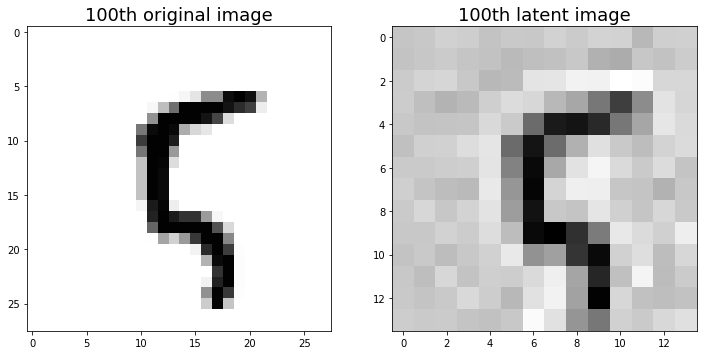

In [ ]:
sample_num = 100

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.imshow(X_image[sample_num].reshape(28, 28), cmap='Greys')
ax1.set_title('100th original image', size=18)
ax2.imshow(mnist_latent[sample_num].reshape(14, 14), cmap='Greys')
ax2.set_title('100th latent image', size=18)

plt.show()

# _2_. Kmeans 군집화: 10그룹


In [ ]:
# Kmeans에 넣기 위해 rehsape
print("원래 latent feature", mnist_latent.shape)
mnist_latent = mnist_latent[:, :, :, 0] # channel 제거: 0
mnist_latent = mnist_latent.reshape(-1, 14*14)
mnist_latent.shape

원래 latent feature (3000, 14, 14, 1)


(3000, 196)

In [ ]:
# Kmeans++ 알고리즘
km = KMeans(n_clusters=10, init='k-means++', n_init=3, max_iter=300, tol=1e-04, random_state=42, verbose=1)
km.fit(mnist_latent)
clust = km.predict(mnist_latent)

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 4697031.5
start iteration
done sorting
end inner loop
Iteration 1, inertia 4531449.0
start iteration
done sorting
end inner loop
Iteration 2, inertia 4478437.5
start iteration
done sorting
end inner loop
Iteration 3, inertia 4454413.5
start iteration
done sorting
end inner loop
Iteration 4, inertia 4439691.5
start iteration
done sorting
end inner loop
Iteration 5, inertia 4430347.5
start iteration
done sorting
end inner loop
Iteration 6, inertia 4420726.5
start iteration
done sorting
end inner loop
Iteration 7, inertia 4411442.0
start iteration
done sorting
end inner loop
Iteration 8, inertia 4403594.5
start iteration
done sorting
end inner loop
Iteration 9, inertia 4394474.5
start iteration
done sorting
end inner loop
Iteration 10, inertia 4383961.0
start iteration
done sorting
end inner loop
Iteration 11, inertia 4373513.5
start iteration
done sorting
end inner loop
Iteration 12, inertia 4364388.

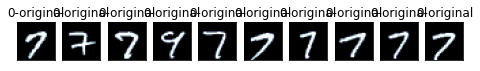

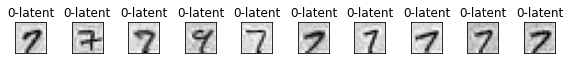

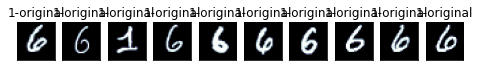

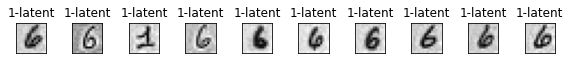

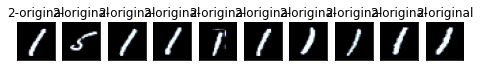

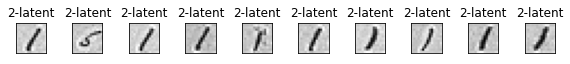

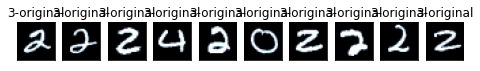

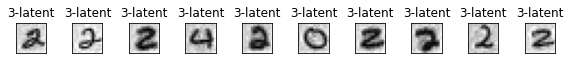

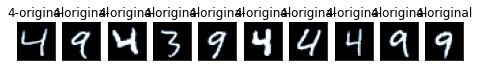

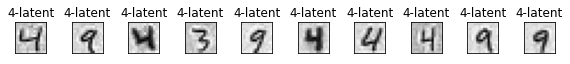

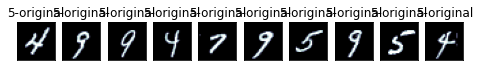

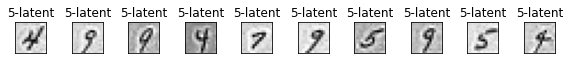

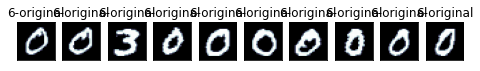

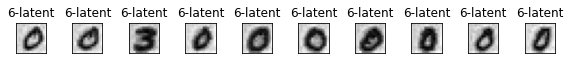

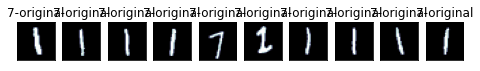

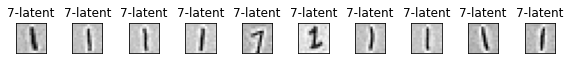

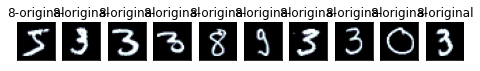

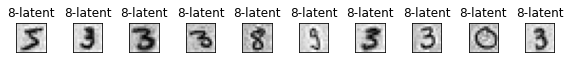

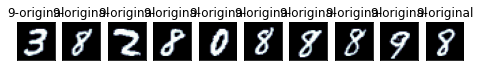

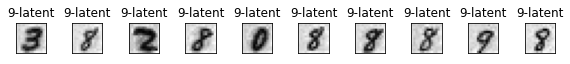

In [ ]:
# 클러스터별 이미지 확인
for k in np.unique(clust):
    # 클러스터가 k인 이미지 10개를 찾는다.
    idx = np.where(clust == k)[0][:10]

    f1 = plt.figure(figsize=(8, 2)) # 원래 이미지
    f2 = plt.figure(figsize=(8, 2)) # latent vector
    for i in range(10):
        image = X_image[idx[i]].reshape(28, 28)        
        ax1 = f1.add_subplot(1, 10, i+1)
        ax1.imshow(image, cmap=plt.cm.bone)
        ax1.grid(False)
        ax1.set_title(f"{k}-original")
        ax1.xaxis.set_ticks([])
        ax1.yaxis.set_ticks([])

        image_latent = mnist_latent[idx[i]].reshape(14, 14)
        ax2 = f2.add_subplot(1, 10, i+1)        
        ax2.imshow(image_latent, cmap='Greys') # 잘 비교되게 하려고 cmap만 변경   
        ax2.grid(False)
        ax2.set_title(f"{k}-latent")
        ax2.xaxis.set_ticks([])
        ax2.yaxis.set_ticks([])

        plt.tight_layout()

# _3_. 전체 과정 activation sigmoid로 변경

In [ ]:
mnist_latent_test = np.copy(mnist_latent)
mnist_latent_test = mnist_latent_test[:, :, np.newaxis, np.newaxis]
mnist_latent_test.shape

(3000, 196, 1, 1)